## Imports

In [1]:
# Standard library imports
import os
import random
import pickle

# Data analysis packages
import numpy as np
import pandas as pd
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm

# Visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrow, Patch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

# Image processing packages
import imageio
from PIL import Image, ImageSequence

# Braingeneers packages for analysis
import braingeneers
import braingeneers.data.datasets_electrophysiology as ephys
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster

import diptest

import pickle

## Data

In [2]:
# with open('/workspaces/human_hippocampus/dev/other/thomas/thesis/pickled_datasets/random_dataset.pkl', 'rb') as file:
#     sd = pickle.load(file)

with open('data/linear_overlap_spike_data2.pkl', 'rb') as file:
    sd = pickle.load(file)


# with open('data/linear_overlap_spike_data.pkl', 'rb') as file:
#     sd = pickle.load(file)

# with open('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/sd_ca1_curated.pkl', "rb") as my_file:
#     sd = pickle.load(my_file)



# with open('/workspaces/human_hippocampus/data/processed/ephys/2023-12-03-e-Hc112823_avv9hckcr1/curated_base_acqm.pkl', 'rb') as file:
#     sd = pickle.load(file)

## Helper Functions

In [4]:
# def local_safe_divide(numerator, denominator):
#     """Safely divide two numbers, returning 0 when the denominator is 0."""
#     return numerator / denominator if denominator != 0 else 0

# def local_sttc_ta(tA, delt, tmax):
#     '''
#     Helper function for spike time tiling coefficients: calculate the
#     total amount of time within a range delt of spikes within the
#     given sorted list of spike times tA.
#     '''
#     if len(tA) == 0:
#         return 0

#     base = min(delt, tA[0]) + min(delt, tmax - tA[-1])
#     return base + np.minimum(np.diff(tA), 2 * delt).sum()

# def local_sttc_na(tA, tB, delt):
#     '''
#     Helper function for spike time tiling coefficients: given two
#     sorted lists of spike times, calculate the number of spikes in
#     spike train A within delt of any spike in spike train B.
#     '''
#     if len(tB) == 0:
#         return 0
#     tA, tB = np.asarray(tA), np.asarray(tB)

#     # Find the closest spike in B after spikes in A.
#     iB = np.searchsorted(tB, tA, side='right')
#     iB = np.clip(iB, 1, len(tB) - 1)

#     dt_left = np.abs(tB[iB - 1] - tA)
#     dt_right = np.abs(tA - tB[np.clip(iB, 0, len(tB) - 1)])

#     # Return how many of those spikes are actually within delt.
#     return np.sum(np.minimum(dt_left, dt_right) <= delt)

# def local_spike_time_tiling(tA, tB, TA, TB, delt):
#     """
#     Internal helper method for the second half of STTC calculation.
#     """
#     PA = local_safe_divide(local_sttc_na(tA, tB, delt), len(tA))
#     PB = local_safe_divide(local_sttc_na(tB, tA, delt), len(tB))

#     aa = local_safe_divide((PA - TB), (1 - PA * TB))
#     bb = local_safe_divide((PB - TA), (1 - PB * TA))
#     return (aa + bb) / 2

# def local_spike_time_tiling_coefficient(tA, tB, delt=20, length=None):
#     """
#     Calculate the spike time tiling coefficient between two spike trains.
#     """
#     if length is None:
#         length = max(tA[-1], tB[-1]) if tA and tB else 0

#     if len(tA) == 0 or len(tB) == 0:
#         return 0.0

#     TA = local_safe_divide(local_sttc_ta(tA, delt, length), length)
#     TB = local_safe_divide(local_sttc_ta(tB, delt, length), length)
#     return local_spike_time_tiling(tA, tB, TA, TB, delt)

# class LocalSpikeData:
#     def __init__(self, train, length, neuron_data):
#         self.train = train
#         self.length = length
#         self.N = len(train)
#         self.neuron_data = neuron_data

#     def local_spike_time_tilings(self, delt=20):
#         """
#         Compute the full spike time tiling coefficient matrix.
#         """
#         T = self.length
#         ts = [local_safe_divide(local_sttc_ta(ts, delt, T), T) for ts in self.train]

#         ret = np.diag(np.ones(self.N))
#         for i in range(self.N):
#             for j in range(i + 1, self.N):
#                 ret[i, j] = ret[j, i] = local_spike_time_tiling(
#                     self.train[i], self.train[j], ts[i], ts[j], delt
#                 )
#         return ret
# sd = LocalSpikeData(sd.train, sd.length, sd.neuron_data)

In [4]:
def latencies_between_two_neurons(train_a, train_b, window_ms=100):
    '''
    Compute latencies between the spike trains of two neurons.
    
    :param train_a: Spike train of the first neuron (numpy array).
    :param train_b: Spike train of the second neuron (numpy array).
    :param window_ms: Window in milliseconds to consider for latency calculation.
    :return: List of lists, where each sublist contains latencies from each spike in train_a
             to spikes in train_b within the specified window.
    '''
    latencies = []
    
    # Check if either of the trains is empty
    if len(train_a) == 0 or len(train_b) == 0:
        return latencies
    
    for spike_a in train_a:
        # Calculate differences between spike_a and all spikes in train_b
        diffs = train_b - spike_a
        # Filter the differences to find those within the specified window
        relevant_latencies = diffs[np.abs(diffs) <= window_ms]
        
        if len(relevant_latencies) > 0:
            latencies.append(relevant_latencies.tolist())
            
    return latencies

In [5]:
def analyze_spike_time_tilings(sd, delta_t, min_spikes, sttc_thresh, mean_thresh, pval_thresh, fwhm_thresh):
    dT = delta_t
    MIN_SPIKES = min_spikes
    N = sd.N
    STTC_THRESH = sttc_thresh
    MEAN_THRESH = mean_thresh
    PVAL_THRESH = pval_thresh
    FWHM_THRESH = fwhm_thresh

    tile_coefficients_whole = np.zeros((N, N))
    mean_latencies = np.nan * np.zeros((N, N))

    # Assume sd.local_spike_time_tilings is a method that exists and returns sttc values
    sttc_values = sd.spike_time_tilings(delt=dT)

    for ref_channel in range(N):
        for comp_channel in range(N):
            if ref_channel == comp_channel:
                continue
            ref_train = sd.train[ref_channel]
            comp_train = sd.train[comp_channel]
            
            # Ensure both channels have a minimum number of spikes
            if len(ref_train) > MIN_SPIKES and len(comp_train) > MIN_SPIKES:
                sttc_value = sttc_values[ref_channel, comp_channel]

                if sttc_value > STTC_THRESH:
                    latencies = latencies_between_two_neurons(ref_train, comp_train, window_ms=dT)

                    # Remove latencies larger than dT
                    latencies = [lat for sublist in latencies for lat in sublist if np.abs(lat) <= dT]

                    if np.abs(np.mean(latencies)) > 0:
                        pdf = np.sort(latencies)

                        # Compute the dip test
                        dip, p_val = diptest.diptest(pdf)

                        if p_val > PVAL_THRESH:
                            pd_mean = np.mean(pdf)
                            pd_std = np.std(pdf)
                            pd_fwhm = 2 * np.sqrt(2 * np.log(2)) * pd_std

                            if pd_fwhm < FWHM_THRESH:
                                mean_latencies[comp_channel, ref_channel] = pd_mean
                                # Adjust storage based on mean latency direction
                                if np.abs(mean_latencies[comp_channel, ref_channel]) > MEAN_THRESH:
                                    tile_coefficients_whole[comp_channel, ref_channel] = sttc_value

    return tile_coefficients_whole, mean_latencies

In [6]:
# Function to get neuron positions
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)

def latencies_mean_neuron(lat_list):
    """
    Output: Returns a list containing the mean latencies for each sublist.
    Input: lat_list- A list of lists representing latencies between a particular neuron, x, and all others. Created with `sd.latencies_to_index(x)`
    """
    nested_list = lat_list
    for i in range(len(nested_list)):
        sublist = nested_list[i]
        length = len(sublist)
        if length == 0:
            sublist_mean = 0
        else:
            sublist_mean = sum(sublist)/len(sublist)
            sublist_mean = round(sublist_mean, 3) # Round to 3d.p.
        nested_list[i] = sublist_mean
    return nested_list

def latencies_mean_all(sd):
    """
    Output: Returns a list of lists containing the mean latencies between all neurons
    Input: sd- A SpikeData object, the standard data format for braingeneers
    """
    latencies_array = [None] * sd.N
    for curr_neuron in range(sd.N):
        latencies = latencies_mean_neuron(sd.latencies_to_index(curr_neuron))
        latencies_array[curr_neuron] = latencies # Store mean latency in corresponding position of 'latencies_array2'
    return latencies_array

def get_in_out_degree( mean_latency_matrix ): 
    """
    Output: Returns a list of tuples, [(incoming,outgoing),....] , containing the in and out degree for each neuron. 
            This is the number of "receicer" and "sender" signals the neurons get from other neurons
    Input: mean_latency_matrix- A list of lists containing the mean latency between all neurons
    """
    in_out_deg = [(0, 0) for _ in range(len(mean_latency_matrix))]
    for curr_neuron in range(len(mean_latency_matrix)):
        in_deg = 0
        out_deg = 0
        curr_neural_latencies = mean_latency_matrix[curr_neuron]
        for i in range(len(curr_neural_latencies)):
            if curr_neural_latencies[i] > 0:
                out_deg += 1
            if curr_neural_latencies[i] < 0:
                in_deg += 1
        in_out_deg[curr_neuron] = (in_deg, out_deg)
    return in_out_deg

def label_sender_receiver_neurons(in_out_deg, latency_thresh=0.2):
    node_info = ['grey'] * len(in_out_deg)
    for i in range(len(in_out_deg)):
        if (in_out_deg[i][1] + in_out_deg[i][0]) == 0:
            test1 = 0
            test2 = 0
        else:
            test1 = (in_out_deg[i][1] - in_out_deg[i][0]) / (in_out_deg[i][1] + in_out_deg[i][0])
            test2 = (in_out_deg[i][0] - in_out_deg[i][1]) / (in_out_deg[i][1] + in_out_deg[i][0])
        
        if test1 > latency_thresh:
            node_info[i] = 'red'
        elif test2 > latency_thresh:
            node_info[i] = 'blue'
    return node_info

def plot_functional_connectivity_map(sd, tile_coefficients_whole, latency_threshold=.1, sttc_threshold=.1, show_sttc=True):
    """
    Output: plots the functional connectivity map, displayin "sender" and ""receiver" neurons in the neural circuit
    Inputs:
        sd (SpikeData object)- the standard data format for braingeneers
        latency_threshold (float)- Between 0-1. The threshold for the fraction of in/out signals a neuron must have to be labelled a "sender" or "receiver"
        show_sttc (boolean)- If True, the spike time tiling connections between neurons are also plotted
        sttc_threshold (float)- Between 0-1. The strength a spike time tiling correlation must be above in order to be plotted
    """
    # Plot functional connectivity map
    print("calculating all latencies...")
    all_mean_latencies = latencies_mean_all(sd)
    in_out_deg = get_in_out_degree(all_mean_latencies)
    sender_receiver_neurons = label_sender_receiver_neurons(in_out_deg, latency_threshold )
    print("making plot")
    neuron_x = []
    neuron_y = []
    for neuron in sd.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    plt.figure(figsize=(8,8))
    plt.scatter(neuron_x, neuron_y, c=sender_receiver_neurons)
    # Plot legend for functional connectivity map
    node_type_legend_elements = [
    plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='grey', label='Broker'),
    plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='red', label='Sender'),
    plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='blue', label='Receiver')
    ]
    node_type_legend = plt.legend(handles=node_type_legend_elements, title='Node Type', loc='best')
    plt.gca().add_artist(node_type_legend)
    plt.title("Functional Connectivity Map - Random Data")
    plt.xlabel('X position')
    plt.ylabel('Y position')

    # Plot spike time tiling connections between neurons
    if show_sttc:
        sttc = tile_coefficients_whole
        for i in range(sttc.shape[0]):
            for j in range(sttc.shape[1]):
                if i <= j: continue
                if sttc[i,j] < sttc_threshold : continue
                ix,iy = sd.neuron_data['positions'][i]['position']
                jx,jy = sd.neuron_data['positions'][j]['position']
                # ix,iy = sd.neuron_data[0][i]['position']
                # jx,jy = sd.neuron_data[0][j]['position']
                linewidth = 1.5 + 2 * (sttc[i, j] - sttc_threshold)
                opacity = 0.2 + 0.8 * (sttc[i, j] - sttc_threshold)  # Modify opacity based on correlation
                # Plot line between the points with linewidth and opacity
                plt.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)
        # Create legend for spike time tilings
        correlation_legend_elements = [
            plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
            plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
            plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
        ]
        correlation_legend = plt.legend(handles=correlation_legend_elements, title='Correlation', loc='lower left')
        plt.gca().add_artist(correlation_legend)
    
    # Invert y axis to match the image
    plt.gca().invert_yaxis()

    # Make x and y axis equal
    plt.axis('equal')

    plt.show()

In [11]:
tile_coef, mean_latencies = analyze_spike_time_tilings(sd, delta_t=20, min_spikes=5, sttc_thresh=0.35, mean_thresh=2, pval_thresh=0.05, fwhm_thresh=35)

calculating all latencies...
making plot


/tmp/ipykernel_27186/3890587790.py:102: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data['positions'].values():
/tmp/ipykernel_27186/3890587790.py:126: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  ix,iy = sd.neuron_data['positions'][i]['position']
/tmp/ipykernel_27186/3890587790.py:127: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  jx,jy = sd.neuron_data['positions'][j]['position']


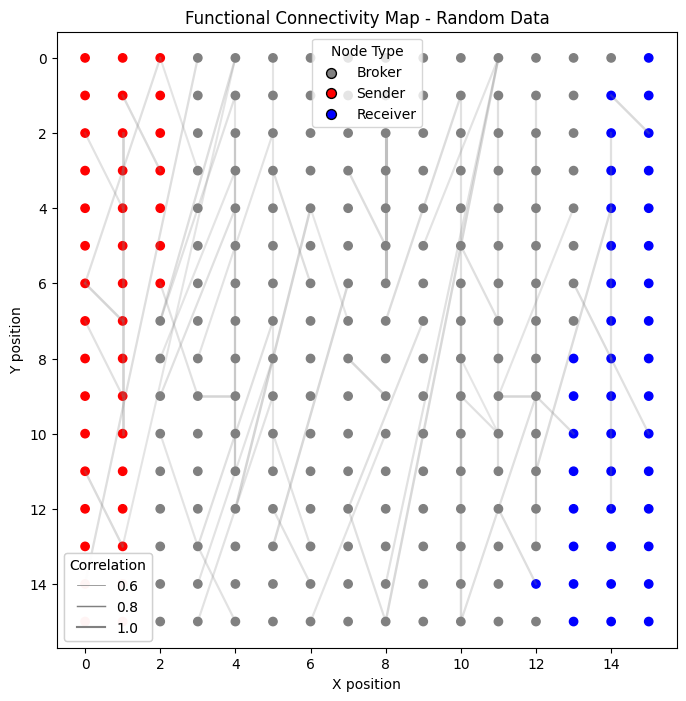

In [12]:
plot_functional_connectivity_map(sd, tile_coef, latency_threshold=.1, sttc_threshold=.35, show_sttc=True)